In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torcheval.metrics

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

import time
import os
import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

In [16]:
X = torch.tensor(np.linspace(0, 20, num = 500), dtype=torch.float32).reshape(-1, 1) #PyTorch expects features in a 2D [n_batch, n_features] tensor
y = X + torch.sin(X)*2 + torch.randn(size=X.shape)
print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)


torch.Size([500, 1])
torch.Size([500, 1])
torch.float32
torch.float32


In [17]:
train_dataset = TensorDataset( X, y)
training_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [18]:
model = nn.Sequential(nn.Linear(1,10), nn.Tanh(), nn.Linear(10,1)).to(device)
optimizer = torch.optim.AdamW(model.parameters())
f_loss = nn.functional.mse_loss
train_network(model, optimizer, f_loss, training_loader_32, epochs=200)


Epoch: 100%|██████████| 200/200 [00:04<00:00, 46.79it/s]


,Last Epoch,Last Time
0,0,0.000000
1,1,0.034046
2,2,0.025033
3,3,0.025526
4,4,0.020024
...,...,...
196,196,0.021053
197,197,0.021528
198,198,0.018521
199,199,0.021522


<Axes: >

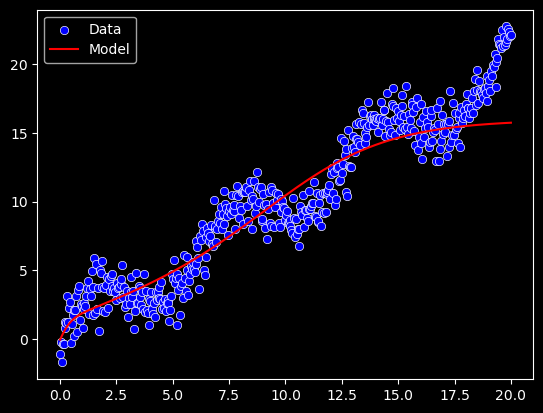

In [19]:
with torch.no_grad():
    model.eval()
    y_hat = model(X.to(device)).cpu().numpy()
    model.train()
sns.scatterplot(x=X.ravel(), y=y.ravel(), color='blue', label='Data')
sns.lineplot(x=X.ravel(), y=y_hat.ravel(), color='red', label='Model')

In [20]:
X_scaled = torch.tensor(StandardScaler().fit_transform(X), dtype=torch.float32).reshape(-1, 1)
y_scaled = torch.tensor(StandardScaler().fit_transform(y), dtype=torch.float32).reshape(-1, 1)
print(torch.std_mean(X_scaled))
print(torch.std_mean(y_scaled))
# sns.scatterplot(x = X_scaled.ravel(), y = y_scaled.ravel())
print(X_scaled.shape)
print(y_scaled.shape)
print(X_scaled.dtype)
print(y_scaled.dtype)

(tensor(1.0010), tensor(-3.2489e-09))
(tensor(1.0010), tensor(4.9174e-10))
torch.Size([500, 1])
torch.Size([500, 1])
torch.float32
torch.float32


In [21]:
train_dataset_scaled = TensorDataset( X_scaled, y_scaled)
training_loader_scaled_32 = DataLoader(train_dataset_scaled, batch_size=32, shuffle=True, pin_memory=True)

In [92]:
# model_scaled = nn.Sequential(
#     nn.Linear(1,10),
#     nn.Tanh(),
#     nn.Linear(10,10),
#     nn.Tanh(),
#     nn.Linear(10,1),
#     ).to(device)

n_neurons = 100
model_scaled = nn.Sequential(
    nn.Linear(1,n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons,n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons,n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons,1),
    ).to(device)

optimizer_scaled = torch.optim.AdamW(model_scaled.parameters())

In [93]:
train_network(model_scaled, optimizer_scaled, f_loss, training_loader_scaled_32, epochs=200)

Epoch: 100%|██████████| 200/200 [00:05<00:00, 35.24it/s]


,Last Epoch,Last Time
0,0,0.000000
1,1,0.050602
2,2,0.032535
3,3,0.029377
4,4,0.031167
...,...,...
196,196,0.027034
197,197,0.026089
198,198,0.027025
199,199,0.026192


<Axes: >

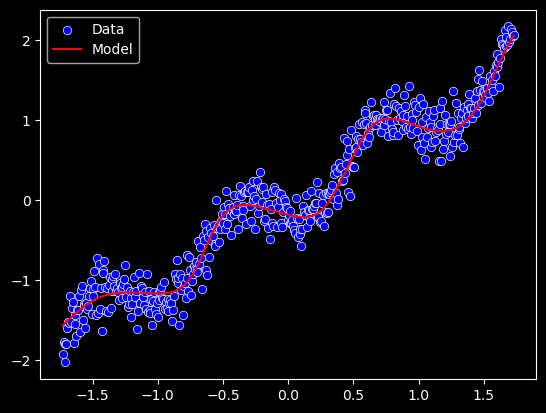

In [94]:
with torch.no_grad():
    model_scaled.eval()
    y_hat_scaled = model_scaled(X_scaled.to(device)).cpu().numpy()
    model_scaled.train()
sns.scatterplot(x=X_scaled.ravel(), y=y_scaled.ravel(), color='blue', label='Data')
sns.lineplot(x=X_scaled.ravel(), y=y_hat_scaled.ravel(), color='red', label='Model')

For this problem it seems that in order to track the sinusoidal pattern, having more neurons per layer is more effective than adding more layers.